### generic model for face detection (based on an object detection model)
### model
- `VGG16` - predefined model for object detection
- input 
    - image [200 x 200]
- output 
    - [0,1] - 0 if face is not present on the image, 1 otherwise
    - x,y,w,h - coordinates of the face on the image
### dictionary
- bounding box - box that marks area where our object is present (in our case face)
### libraries 
- `labelme` - Library that contains method that we will use to label data


In [3]:
from pathlib import Path # to get the path of the current file
import time # to measure time
import uuid # for unique id
import cv2
import os
import random

# collect data

In [4]:
DATA_PATH = Path.cwd() / 'data'  # path to the data folder
IMAGES_NUMBER = 0
DATA_PATH.mkdir(parents=True, exist_ok=True)


In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range(IMAGES_NUMBER):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    if ret:
        imgname = os.path.join(DATA_PATH,f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)
        time.sleep(0.5)
    else:
        print('Error: No image captured')
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [2]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
images = tf.data.Dataset.list_files(str(DATA_PATH /'train'/'images'/'*.jpg'))


In [7]:
def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image)
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image

In [8]:
images.as_numpy_iterator().next()

b'c:\\Users\\skibi\\Desktop\\learning\\project\\data\\train\\images\\12493f4a-466c-11ed-a40a-b42e994c644b.jpg'

In [9]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [10]:
images = images.map(load_image)

In [11]:
images.as_numpy_iterator().next().shape

(480, 640, 3)

In [12]:
HEIGHT,WIDTH = images.as_numpy_iterator().next().shape[0], images.as_numpy_iterator().next().shape[1]
print(WIDTH, HEIGHT)
NEW_WIDTH, NEW_HEIGHT = 96, 96

640 480


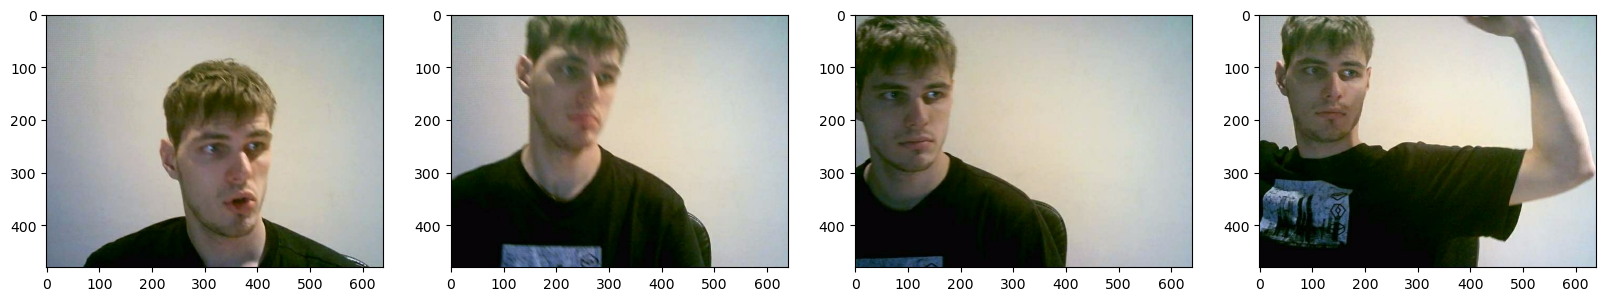

In [13]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## here split data mannualy


In [14]:
for folder in ['train','test']:
    for file in os.listdir(os.path.join(DATA_PATH, folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join(DATA_PATH,'labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [15]:
import albumentations as alb

In [16]:
augmentor = alb.Compose([alb.RandomCrop(width=WIDTH, height=HEIGHT), 
                        alb.HorizontalFlip(p=0.5), 
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2), 
                        alb.RGBShift(p=0.2), 
                        alb.VerticalFlip(p=0.5)], 
                        bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [17]:

label = json.load(open(os.path.join(DATA_PATH,'train','labels','07dc5ad4-466c-11ed-aaf7-b42e994c644b.json')))
image = cv2.imread(os.path.join(DATA_PATH,'train','images','07dc5ad4-466c-11ed-aaf7-b42e994c644b.jpg'))

In [18]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [19]:
coords = list(np.divide(coords, [WIDTH, HEIGHT, WIDTH, HEIGHT]))
coords

[0.2847014925373134,
 0.2860696517412935,
 0.5629975124378108,
 0.7483416252072969]

In [20]:
augmented = augmentor(image=image, bboxes=[coords], class_labels=['face'])
augmented

{'image': array([[[177, 167, 137],
         [177, 167, 137],
         [178, 168, 138],
         ...,
         [171, 162, 152],
         [171, 161, 151],
         [171, 161, 151]],
 
        [[177, 167, 137],
         [177, 167, 137],
         [178, 168, 138],
         ...,
         [170, 161, 151],
         [170, 160, 150],
         [170, 160, 150]],
 
        [[177, 167, 137],
         [177, 167, 137],
         [178, 168, 138],
         ...,
         [164, 156, 143],
         [165, 156, 143],
         [164, 155, 142]],
 
        ...,
 
        [[188, 181, 166],
         [189, 182, 167],
         [190, 183, 168],
         ...,
         [ 57,  54,  49],
         [ 59,  56,  51],
         [ 62,  59,  54]],
 
        [[188, 181, 166],
         [189, 182, 167],
         [190, 183, 168],
         ...,
         [ 57,  54,  49],
         [ 60,  57,  52],
         [ 62,  59,  54]],
 
        [[188, 181, 166],
         [189, 182, 167],
         [190, 183, 168],
         ...,
         [ 57,  54,

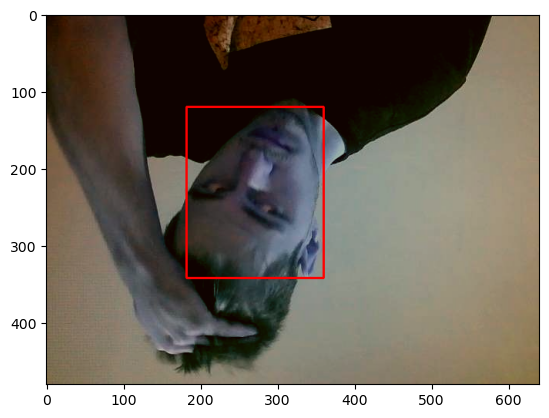

In [77]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [WIDTH,HEIGHT]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [WIDTH,HEIGHT]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [21]:
def create_folders_for_data(data_path):
    for folder in ['train', 'test']:
        for subfolder in ['images', 'labels']:
            os.makedirs(os.path.join(data_path, folder, subfolder), exist_ok=True)

In [22]:
def save_images():
    for partition in ['train','test']: 
        for image in os.listdir(os.path.join('data', partition, 'images')):
            img = cv2.imread(os.path.join('data', partition, 'images', image))

            coords = [0,0,0.00001,0.00001]
            label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = json.load(f)

                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords, [WIDTH, HEIGHT,WIDTH, HEIGHT]))

            try: 
                for x in range(60):
                    augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                    cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                    annotation = {}
                    annotation['image'] = image

                    if os.path.exists(label_path):
                        if len(augmented['bboxes']) == 0: 
                            annotation['bbox'] = [0,0,0,0]
                            annotation['class'] = 0 
                        else: 
                            annotation['bbox'] = augmented['bboxes'][0]
                            annotation['class'] = 1
                    else: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 


                    with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                        json.dump(annotation, f)

            except Exception as e:
                print(e)


In [23]:
create_folders_for_data('aug_data')
save_images()

x_max is less than or equal to x_min for bbox [0.40130597014925373, 0.25497512437810943, 0.11756840796019899, 0.8385157545605306, 'face'].
x_max is less than or equal to x_min for bbox [0.6726057213930348, 0.6021973466003315, 0.3297885572139303, 0.005182421227197346, 'face'].
x_max is less than or equal to x_min for bbox [0.5311256218905471, 0.5296434494195688, 0.26449004975124374, 0.018656716417910446, 'face'].
x_max is less than or equal to x_min for bbox [0.289365671641791, 0.3928275290215588, 0.07792288557213929, 0.016583747927031506, 'face'].
x_max is less than or equal to x_min for bbox [0.2885883084577114, 0.5451907131011607, 0.01651119402985073, 0.03420398009950248, 'face'].
x_max is less than or equal to x_min for bbox [0.5062499999999999, 0.49751243781094523, 0.24894278606965167, 0.04145936981757877, 'face'].
x_max is less than or equal to x_min for bbox [0.3181281094527363, 0.4840381426202321, 0.11912313432835817, 0.06944444444444443, 'face'].
x_max is less than or equal to 